# SimpleRNN을 이용한 SMS Span 분류
- 캐글 데이터 

In [11]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [12]:
df = pd.read_csv(url, encoding = "latin1")
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [13]:
# Selection
df = df[['v1', 'v2']]
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [14]:
# Null data check
df.isna().sum()

v1    0
v2    0
dtype: int64

In [15]:
# 중복 데이터 확인
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [16]:
df.drop_duplicates(subset = ["v2"], inplace = True)
df.shape

(5169, 2)

In [17]:
# ["ham", "spam"] --> [0, 1]
df.v1 = df.v1.replace(["ham","spam"], [0,1])
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [18]:
# Ham/Spam 분포
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [19]:
# 전처리완료된 파일을 만들어둔다.
df.to_csv("스팸_전처리완료.csv", index = False)

In [20]:
x, y = df.v2.values, df.v1.values
x.shape, y.shape

((5169,), (5169,))

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
# encoding, 구둣점 제거, 소문자로 변환
import re
def preprocessing(s):
    s = s.encode("utf8").decode('ascii', 'ignore')
    s = re.sub("[^a-z0-9 ]","", s.lower())
    return s

In [24]:
X_data = [preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [25]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9479

In [28]:
sequences = t.texts_to_sequences(X_data)

In [29]:
# sequence 중에서 제일 길이가 긴 것
max_len = max(len(seq) for seq in sequences)
max_len

171

In [30]:
data = pad_sequences(sequences, maxlen = max_len)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y, stratify = y, test_size = 0.2, random_state = 2022
)

In [33]:
X_train.shape, X_test.shape

((4135, 171), (1034, 171))

In [ ]:
vocab_size

### 모델 정의/설정/학습

In [34]:
import numpy as np
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [42]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [59]:
model = Sequential([
        Embedding(vocab_size, 32, input_length = max_len),
        SimpleRNN(32),
        Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 171, 32)           303328    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile("adam", "binary_crossentropy", ["accuracy"])

In [61]:
model_path = "best-spam-v1.h5"
mc = ModelCheckpoint(model_path, save_best_only = True, verbose = 1)
es = EarlyStopping(patience = 10)

In [58]:
hist = model.fit(X_train, y_train, epochs = 100, callbacks = [mc, es],
                 validation_split = 0.2, batch_size = 64)

Epoch 1/100


ValueError: ignored

In [ ]:
best_model = load_model(model_path)

In [53]:
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 18ms/step - loss: 0.1124 - accuracy: 0.1267


[0.11240212619304657, 0.12669245898723602]

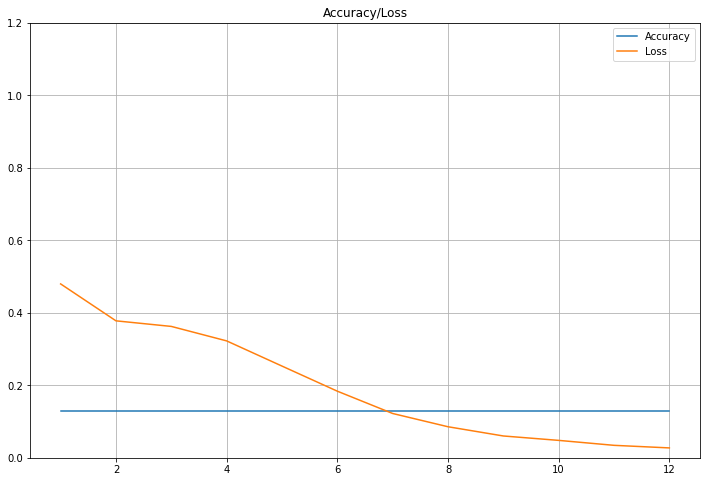

In [45]:
import matplotlib.pyplot as plt

y_acc = hist.history["accuracy"]
y_loss = hist.history["loss"]
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label="Accuracy")
plt.plot(xs, y_loss, label="Loss")
plt.grid(),plt.legend(),plt.title("Accuracy/Loss")
plt.ylim(0,1.2)
plt.show()